In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Импорт данных

In [58]:
netflix_gs_uri = 'https://docs.google.com/spreadsheets/d/1Tc_aiVXrCrMNQFFDMiJGQ3Gm35szGLps_FIsonCe38Q'
basic_sheet = netflix_gs_uri + '/export?gid=0&format=csv'
standard_sheet = netflix_gs_uri + '/export?gid=720312140&format=csv'
premium_sheet = netflix_gs_uri + '/export?gid=41907226&format=csv'
price_sheet = netflix_gs_uri + '/export?gid=481487463&format=csv'


netflix = {
    'basic': pd.read_csv(basic_sheet),
    'standard': pd.read_csv(standard_sheet),
    'premium': pd.read_csv(premium_sheet)
}


In [59]:
income = pd.read_html('https://www.worlddata.info/average-income.php')[0]

In [115]:
income_uri = 'https://www.numbeo.com/cost-of-living/prices_by_country.jsp?displayCurrency=USD&itemId=105'
income = pd.read_html(income_uri)[1]

## Предобработка данных

### Средних доход в сранах

In [118]:
income_pr = income.copy()
income_pr.columns = ['rank', 'country', 'ppp']
income_pr['country'] = income_pr['country'].str.lower()
income_pr['ppp'] = income_pr['ppp'].astype(float)

### Данные по Netflix

In [120]:
def preprocessing(netflix: dict) -> pd.DataFrame:
    netflix = netflix.copy()
    
    for name, df in netflix.items():
        netflix[name] = (
            df
            .pipe(columns_preprocessing)
            .dropna(axis=0)
            .applymap(lambda val: val.lower() if isinstance(val, str) else val)
            .assign(tariff=name)
            .rename(columns={
                name: 'price',
                'average_total_library_size': 'total_library_size'
            })
        )
        
    netflix_pr = pd.concat([
        netflix['basic'],
        netflix['standard'],
        netflix['premium'],
    ], axis=0)
        
    return netflix_pr

def columns_preprocessing(df: pd.DataFrame) -> pd.DataFrame:
    df = df.rename(columns=lambda col: col.lower().replace('#', '').strip().replace(' ', '_')
    )
    needed_columns = filter(lambda col: not col.startswith('unnamed'), df.columns)
    return df[needed_columns]

In [121]:
netflix_pr = preprocessing(netflix)

### Объединение данных

In [122]:
stats = netflix_pr.merge(income_pr, on='country', how='left')

## Анализ данных

### Построить график корреляции между средним доходом и ценой подписки

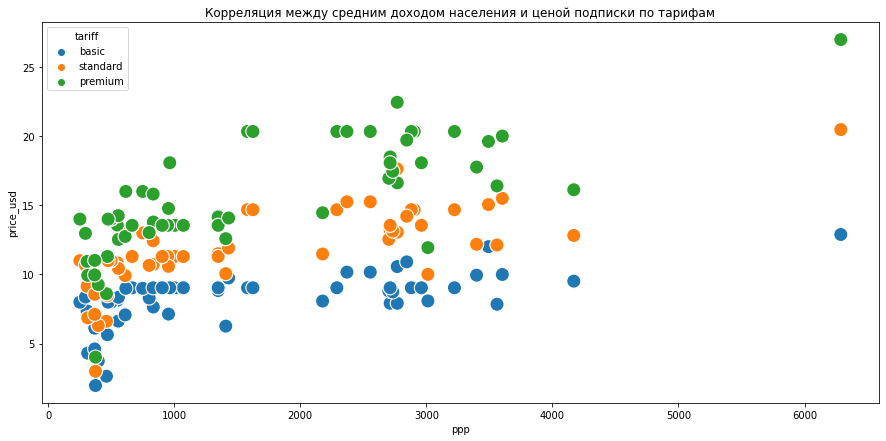

In [123]:
plt.figure(figsize=(15, 7))
sns.scatterplot(data=stats, x='ppp', y='price_usd', hue='tariff', s=200)
plt.title('Корреляция между средним доходом населения и ценой подписки по тарифам')
plt.show()

### Какая средняя цена подписки, (базовой, стандартной, премиум) в зависимости от валюты страны?

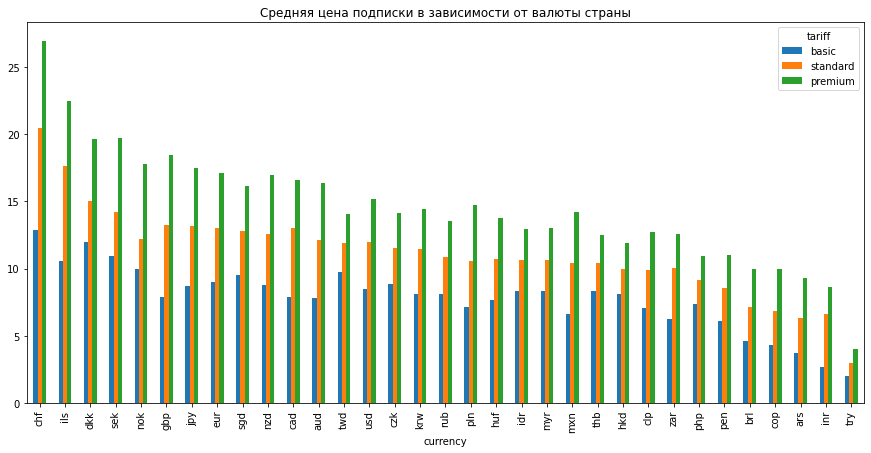

In [124]:
avg_price_per_currency_and_tariff = stats\
.pivot_table(index='currency', columns='tariff', values='price_usd', aggfunc='mean')\
.assign(sort_cols=lambda x: x.mean(axis=1))\
.sort_values('sort_cols', ascending=False)\
.drop(['sort_cols'], axis=1)\
[['basic', 'standard', 'premium']]

avg_price_per_currency_and_tariff.plot.bar(
    title='Cредняя цена подписки в зависимости от валюты страны',
    figsize=(15, 7)
);

### Какая средняя цена подписки, (базовой, стандартной, премиум) в зависимости от континента?

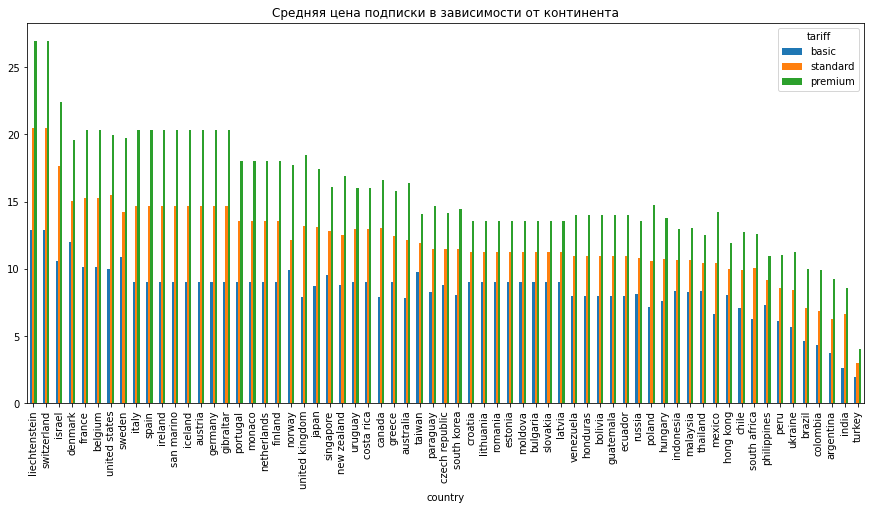

In [125]:
avg_price_per_country_and_tariff = stats\
.pivot_table(index=['country'], columns='tariff', values='price_usd', aggfunc='mean')\
.assign(sort_cols=lambda x: x.mean(axis=1))\
.sort_values('sort_cols', ascending=False)\
.drop(['sort_cols'], axis=1)\
[['basic', 'standard', 'premium']]

avg_price_per_country_and_tariff.plot.bar(
    title='Cредняя цена подписки в зависимости от континента',
    figsize=(15, 7)
);

### Сколько стоит подписка относительно среднего дохода (базовая, стандартная, премиум) в Чехии?

In [127]:
price_per_ppp_from_czech = (
    stats
    [stats['country'] == 'czech republic']
    .assign(price_per_ppp=lambda row: row['price_usd'] / row['ppp'])
    [['tariff', 'price_per_ppp']]
)
price_per_ppp_from_czech.style.format({'price_per_ppp': lambda x: f'{x:.2%}'})

,tariff,price_per_ppp
10,basic,0.65%
72,standard,0.85%
134,premium,1.05%


### Какие топ-5 стран имеют самую большую доступную коллекцию сериалов?

In [128]:
stats.groupby('country')['of_movies'].max().nlargest(5).reset_index()

,country,of_movies
0,malaysia,2387.0
1,philippines,2208.0
2,singapore,2194.0
3,india,2125.0
4,united kingdom,2092.0


### Какой процент среднего дохода россиянина будет составлять подписка Netflix?

In [129]:
price_per_ppp_from_russia = (
    stats
    [stats['country'] == 'russia']
    .assign(price_per_ppp=lambda row: row['price_usd'] / row['ppp'])
    [['tariff', 'price_per_ppp']]
)
price_per_ppp_from_russia.style.format({'price_per_ppp': lambda x: f'{x:.2%}'})

,tariff,price_per_ppp
25,basic,1.48%
82,standard,1.97%
147,premium,2.47%


### На каком месте будет Россия, если отсортировать страны по эффективности подписки (Cost Per Title)?

In [130]:
(
    netflix_pr
    .sort_values('price_per_title', ascending=False)
    .assign(rn=lambda df: df.groupby('tariff').cumcount()+1)
    .query('country == "russia"')
    [['country', 'tariff', 'rn']]
)

,country,tariff,rn
25,russia,basic,41
17,russia,standard,48
17,russia,premium,48


### В какой стране лучше всего брать VPN для того, чтобы платить за Netflix меньше всего?

In [131]:
stats.sort_values('price_usd').groupby('tariff').head(1)[['country', 'tariff', 'price_usd']]

,country,tariff,price_usd
0,turkey,basic,1.97
65,turkey,standard,3.00
130,turkey,premium,4.02
